# Question 1

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

def dRdt(R, S, X, k1 = 2, k2 = 2):
    return k1 * S - k2 * X * R

def dXdt(X, S, R, k3 = 1, k4 = 1):
    return k3 * S - k4 * X

def equilibriumX(k3, k4, S):
    return k3 * S / k4

def equilibriumR(k1, k2, S, X):
    return (k1 * S) / (k2 * X)

def system(y, t, S, k1, k2, k3, k4):
    R, X = y
    
    return np.array([dRdt(R, S, X, k1, k2), dXdt(X, S, R, k3, k4)])

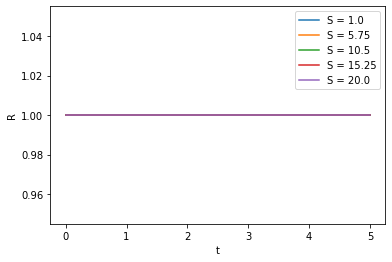

In [9]:
k1 = k2 = 2
k3 = k4 = 1

t_values = np.linspace(0, 5, 50)

for S in np.linspace(1, 20, 5):
    X = equilibriumX(k3, k4, S)
    R = equilibriumR(k1, k2, S, X)
    
    rate = odeint(system, y0 = [R, X], t = t_values, args = (S, k1, k2, k3, k4)).transpose()[0]
    plt.plot(t_values, rate, label=f"S = {S}")
    
plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.show()